<a href="https://colab.research.google.com/github/SamAdebisi/Computer-Vision-using-PyTorch/blob/main/models/VGG_with_fe_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from torchvision import transforms

# Define a common image size for VGG16
image_size = 224

# Augmentation and transformation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),  # Crop the given image to random size and aspect ratio.
    transforms.RandomHorizontalFlip(),         # Horizontally flip the image randomly with a given probability.
    transforms.RandomRotation(15),             # Random rotation of the image by 15 degrees.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change the brightness, contrast, and saturation of an image.
    transforms.ToTensor(),                    # Convert the image to tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with mean and standard deviation.
])

# Standard transformation for test
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize all images to 299x299 pixels.
    transforms.CenterCrop(image_size),            # Crop the center of the image to make a square of 299x299.
    transforms.ToTensor(),                        # Convert the image to tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with mean and standard deviation.
])


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Human Action Recognition.zip to Human Action Recognition.zip


In [4]:
import zipfile
import os

# Update the path to the correct location of the zip file
zip_file_path = 'Human Action Recognition.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Update extraction path if needed
    extraction_path = ''
    zip_ref.extractall(extraction_path)

# Update paths accordingly
train_data_path = 'Human Action Recognition/train'
test_data_path = 'Human Action Recognition/test'

In [5]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

In [6]:
# Create DataLoader for training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the feature extractor layers and the earlier classifier layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier part of the model to match the number of classes (5 classes)
vgg16.classifier[6] = nn.Linear(4096, 5)

# Move the model to the device
model = vgg16.to(device)

In [8]:
# Define the loss function and the optimizer (only train the last classification layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

In [10]:
# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

Epoch [1/20], Train Loss: 1.7241, Train Accuracy: 17.84%
Test Loss: 1.6744, Test Accuracy: 15.71%
Updated best model with accuracy: 15.71%
Epoch [2/20], Train Loss: 1.7345, Train Accuracy: 16.55%
Test Loss: 1.6744, Test Accuracy: 15.71%
Epoch [3/20], Train Loss: 1.7326, Train Accuracy: 17.90%
Test Loss: 1.6744, Test Accuracy: 15.71%
Epoch [4/20], Train Loss: 1.7276, Train Accuracy: 17.54%
Test Loss: 1.6744, Test Accuracy: 15.71%
Epoch [5/20], Train Loss: 1.7172, Train Accuracy: 17.25%
Test Loss: 1.6744, Test Accuracy: 15.71%
Epoch [6/20], Train Loss: 1.7268, Train Accuracy: 16.50%
Test Loss: 1.6744, Test Accuracy: 15.71%
Epoch [7/20], Train Loss: 1.7238, Train Accuracy: 17.42%
Test Loss: 1.6744, Test Accuracy: 15.71%
Stopping early: no improvement after five consecutive epochs.


In [11]:
# Load the best model for evaluation
vgg16.load_state_dict(torch.load('best_model.pth'))
vgg16.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the best model on the test images: {100 * correct / total:.2f}%')

Accuracy of the best model on the test images: 15.71%


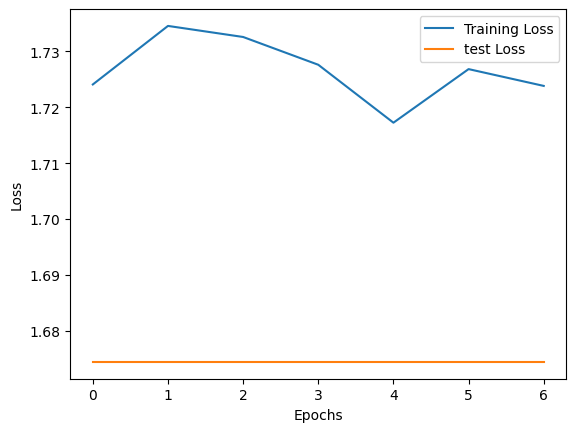

In [12]:
import matplotlib.pyplot as plt

# Plotting the epochs vs training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()